# Image to Parquet
Convert images to binary and save them into a parquet file.

In [1]:
import site
from pathlib import Path
from pyspark.sql import SparkSession

def get_gcs_connector_jar() -> str:
    # Assuming the JAR is installed in the user site-packages of PySpark
    user_site_packages = site.getusersitepackages()
    jars_dir = Path(user_site_packages) / 'pyspark' / 'jars'
    # Search for the GCS connector JAR
    jar = [jar for jar in jars_dir.glob('gcs-connector-hadoop3-*.jar')]
    return str(jar[0])

gcs_connector_jar = get_gcs_connector_jar()
# Initialize Spark Session
spark = (
    SparkSession.builder
    .appName("Image2Parquet")
    .master("local[*]")
    .config("spark.jars", gcs_connector_jar)
    .getOrCreate()
)
print(spark)

24/01/27 14:19:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Set Hadoop configurations for GCS
sc = spark.sparkContext
sc._jsc.hadoopConfiguration().set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
sc._jsc.hadoopConfiguration().set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")

In [3]:
import os
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)

# Base directory using pathlib
curr_dir = Path(os.getcwd())
base_dir = curr_dir.parents[1]
data_dir = base_dir / "data" / "SnakeCLEF2023-small_size" / "2023"
num_folders = 20

# Ensure base directory exists
if not data_dir.is_dir():
    raise FileNotFoundError(f"Data directory {data_dir} does not exist.")

# Getting subfolders
subfolders = sorted([f.name for f in data_dir.iterdir() if f.is_dir()])[:num_folders]

In [4]:
# Schema for the DataFrame
from pyspark.sql.types import StructType, StructField, BinaryType, StringType
schema = StructType([
    StructField("path", StringType(), True),
    StructField("folder_name", StringType(), True),
    StructField("year", StringType(), True),
    StructField("binomial_name", StringType(), True),
    StructField("file_name", StringType(), True),
    StructField("image_binary_data", BinaryType(), True)
])

# Function to convert image to binary
def image_to_binary(image_path):
    with open(image_path, 'rb') as file:
        return file.read()

In [5]:
# Create an empty RDD
image_rdd = spark.sparkContext.emptyRDD()

# Loop through subfolders and process images
for folder in subfolders:
    folder_path = data_dir / folder
    for img_name in os.listdir(folder_path):
        img_path = folder_path / img_name
        relative_path = img_path.relative_to(base_dir)  # Get relative path
        relative_path = str(relative_path).split("data/")[-1]
        folder_name = relative_path.split("/")[0]
        year = relative_path.split("/")[1]
        binomial_name = relative_path.split("/")[2]
        file_name = relative_path.split("/")[-1]
        # print(f"{folder_name}, {year}, {binomial_name}, {file_name}")
        binary_data = image_to_binary(str(img_path))
        image_rdd = image_rdd.union(spark.sparkContext.parallelize([(
            relative_path, folder_name, year,
            binomial_name, file_name, binary_data,
        )]))

In [6]:
# Convert RDD to DataFrame
image_df = spark.createDataFrame(image_rdd, schema)

# Show the first few rows of image_df
image_df.show(n=5)

+--------------------+--------------------+----+--------------------+--------------+--------------------+
|                path|         folder_name|year|       binomial_name|     file_name|   image_binary_data|
+--------------------+--------------------+----+--------------------+--------------+--------------------+
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023|Acanthophis_antar...|250558438.jpeg|[FF D8 FF E0 00 1...|
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023|Acanthophis_antar...|250558444.jpeg|[FF D8 FF E0 00 1...|
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023|  Acanthophis_laevis|250489238.jpeg|[FF D8 FF E0 00 1...|
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023|Acanthophis_prael...| 252303073.jpg|[FF D8 FF E0 00 1...|
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023| Acanthophis_rugosus| 250956644.jpg|[FF D8 FF E0 00 1...|
+--------------------+--------------------+----+--------------------+--------------+--------------------+
only showing top 5 rows



In [7]:
# Base directory for parquet_files folder
data_dir = Path(os.getcwd()).parents[1] / "data"

# Create "parquet_files" directory if it doesn't exist
parquet_dir = data_dir / "parquet_files"
os.makedirs(parquet_dir, exist_ok=True)

In [8]:
# Path to the Parquet file
parquet_file_path = parquet_dir / "images_data.parquet"

# Save the DataFrame as a Parquet file
image_df.write.mode("overwrite").parquet(str(parquet_file_path))

In [9]:
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- folder_name: string (nullable = true)
 |-- year: string (nullable = true)
 |-- binomial_name: string (nullable = true)
 |-- file_name: string (nullable = true)
 |-- image_binary_data: binary (nullable = true)



In [10]:
def get_size_of_parquet(dir_path):
    total_size = 0
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            total_size += os.path.getsize(os.path.join(root, file))
    return total_size

# Get the size of the Parquet file (directory)
parquet_size = get_size_of_parquet(parquet_file_path)
print(f"Size of Parquet file: {parquet_size} bytes")

Size of Parquet file: 2979727 bytes


In [11]:
# Define the GCS path
gcs_path = "gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data"

# Write the DataFrame to GCS
image_df.write.mode("overwrite").parquet(gcs_path)

## Load DataFrame from GCS

In [5]:
# Define the GCS path to the Parquet file
gcs_parquet_path = "gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data"

# Read the Parquet file into a DataFrame
df = spark.read.parquet(gcs_parquet_path)

# Show the data (for example, first few rows)
df.show(n=3)

+--------------------+--------------------+----+-----------------+--------------+--------------------+
|                path|         folder_name|year|    binomial_name|     file_name|   image_binary_data|
+--------------------+--------------------+----+-----------------+--------------+--------------------+
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023|Ahaetulla_prasina|252657757.jpeg|[FF D8 FF E0 00 1...|
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023|Ahaetulla_prasina|250805116.jpeg|[FF D8 FF E0 00 1...|
|SnakeCLEF2023-sma...|SnakeCLEF2023-sma...|2023|Ahaetulla_prasina|250805123.jpeg|[FF D8 FF E0 00 1...|
+--------------------+--------------------+----+-----------------+--------------+--------------------+
only showing top 3 rows



In [41]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param image_data_list: List of binary image data.
    :param binomial_names: List of binomial names corresponding to each image.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12), dpi=80)

    # Flatten the axes array for easy iteration if it's 2D
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax, binary_data, name in zip(axes, image_data_list, binomial_names):
        # Convert binary data to an image and display it
        image = Image.open(io.BytesIO(binary_data))
        ax.imshow(image)
        name = name.replace("_", " ")
        ax.set_xlabel(name)  # Set the binomial name as xlabel
        ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

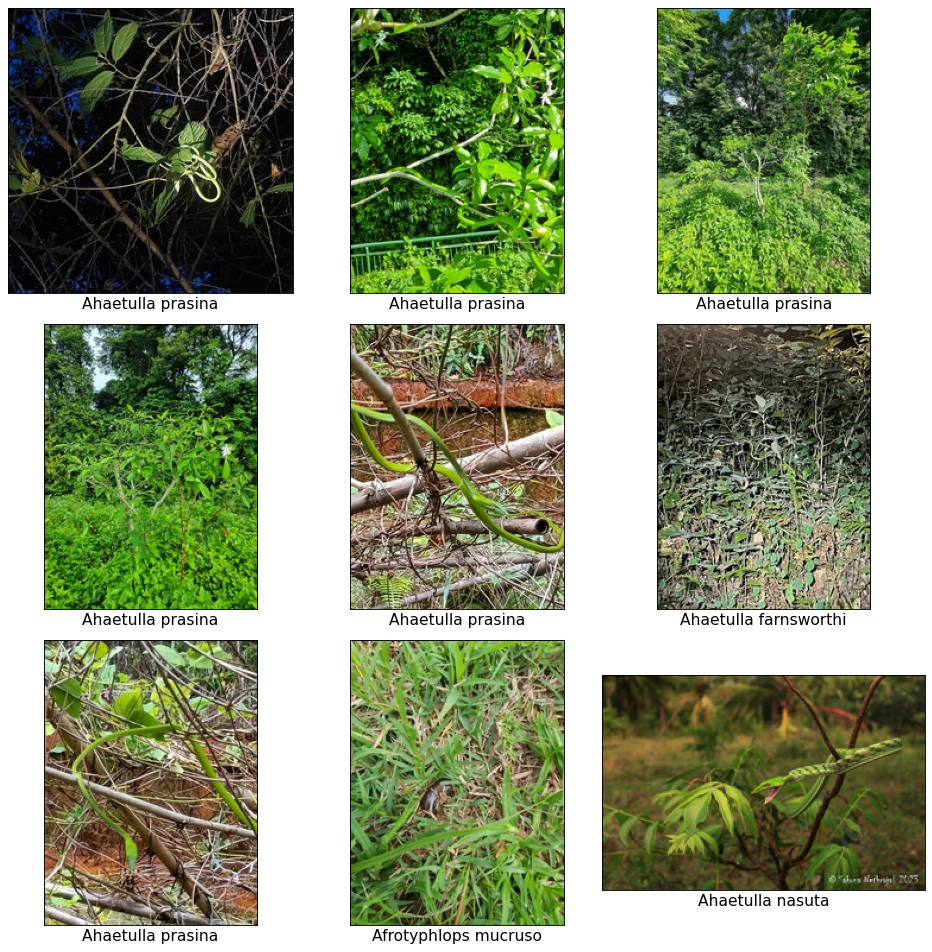

In [42]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
image_data_list = [row['image_binary_data'] for row in df.limit(rows*cols).collect()]
binomial_names = [row['binomial_name'] for row in df.limit(rows*cols).collect()]

# Display the images in a grid with binomial names
display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))